In [1]:
!pip install --quiet "pytorch-lightning"
!pip install --upgrade gdown --quiet
!pip install -q matplotlib
!pip install -q kornia
!pip install -q opencv-python
!pip install -q scipy
!pip install -q numpy
!pip install -q torchvision
!pip install -q tensorboardX
!pip install -q tqdm
# !pip install -q wandb
!pip install -q kaggle

In [2]:
# from kaggle_secrets import UserSecretsClient
# import wandb
# user_secrets = UserSecretsClient()

# # I have saved my API token with "wandb_api" as Label. 
# # If you use some other Label make sure to change the same below. 
# wandb_api = user_secrets.get_secret("wandb-key") 

# wandb.login(key=wandb_api)

In [3]:
# Initialize WandB
# wandb.init(project='anomaly-cifar10')

In [4]:
# config = wandb.config
# config.image_size = 32
# config.patch_size = 4
# config.latent_dim = 1024
# config.num_heads = 4

# config.device = "cuda"
# config.out_features = 3


In [5]:
import torch
import torch.nn.functional as F
import random

def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.2):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, ratio=0.5):
    if random.random() < 0.3:
        cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
        offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
        offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
        grid_batch, grid_x, grid_y = torch.meshgrid(
            torch.arange(x.size(0), dtype=torch.long, device=x.device),
            torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
            torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
        )
        grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
        grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
        mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
        mask[grid_batch, grid_x, grid_y] = 0
        x = x * mask.unsqueeze(1)
    return x

def rand_rotate(x, ratio=0.5):
    k = random.randint(1,3)
    if random.random() < ratio:
        x = torch.rot90(x, k, [2,3])
    return x

AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
    'rotate': [rand_rotate],
}

In [6]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_feat, hid_feat=None, out_feat=None,
                 dropout=0.):
        super().__init__()
        if not hid_feat:
            hid_feat = in_feat
        if not out_feat:
            out_feat = in_feat
        self.fc1 = nn.Linear(in_feat, hid_feat)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hid_feat, out_feat)
        self.droprateout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return self.droprateout(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, attention_dropout=0., proj_dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = 1./dim**0.5

        self.qkv = nn.Linear(dim, dim*3, bias=False)
        self.attention_dropout = nn.Dropout(attention_dropout)
        self.out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(proj_dropout)
        )

    def forward(self, x):
        b, n, c = x.shape
        qkv = self.qkv(x).reshape(b, n, 3, self.heads, c//self.heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)

        dot = (q @ k.transpose(-2, -1)) * self.scale
        attn = dot.softmax(dim=-1)
        attn = self.attention_dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.out(x)
        return x

class ImgPatches(nn.Module):
    def __init__(self, input_channel=3, dim=768, patch_size=4):
        super().__init__()
        self.patch_embed = nn.Conv2d(input_channel, dim,
                                     kernel_size=patch_size, stride=patch_size)

    def forward(self, img):
        patches = self.patch_embed(img).flatten(2).transpose(1, 2)
        return patches

def UpSampling(x, H, W):
        B, N, C = x.size()
        assert N == H*W
        x = x.permute(0, 2, 1)
        x = x.view(-1, C, H, W)
        x = nn.PixelShuffle(2)(x)
        B, C, H, W = x.size()
        x = x.view(-1, C, H*W)
        x = x.permute(0,2,1)
        return x, H, W

class Encoder_Block(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads, drop_rate, drop_rate)
        self.ln2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, dim*mlp_ratio, dropout=drop_rate)

    def forward(self, x):
        x1 = self.ln1(x)
        x = x + self.attn(x1)
        x2 = self.ln2(x)
        x = x + self.mlp(x2)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, depth, dim, heads, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.Encoder_Blocks = nn.ModuleList([
            Encoder_Block(dim, heads, mlp_ratio, drop_rate)
            for i in range(depth)])

    def forward(self, x):
        for Encoder_Block in self.Encoder_Blocks:
            x = Encoder_Block(x)
        return x

class Generator(nn.Module):
    """docstring for Generator"""
    def __init__(self, depth1=5, depth2=4, depth3=2, initial_size=8, dim=384, heads=4, mlp_ratio=4, drop_rate=0.):#,device=device):
        super(Generator, self).__init__()

        #self.device = device
        self.initial_size = initial_size
        self.dim = dim
        self.depth1 = depth1
        self.depth2 = depth2
        self.depth3 = depth3
        self.heads = heads
        self.mlp_ratio = mlp_ratio
        self.droprate_rate =drop_rate

        self.mlp = nn.Linear(1024, (self.initial_size ** 2) * self.dim)

        self.positional_embedding_1 = nn.Parameter(torch.zeros(1, (8**2), 384))
        self.positional_embedding_2 = nn.Parameter(torch.zeros(1, (8*2)**2, 384//4))
        self.positional_embedding_3 = nn.Parameter(torch.zeros(1, (8*4)**2, 384//16))

        self.TransformerEncoder_encoder1 = TransformerEncoder(depth=self.depth1, dim=self.dim,heads=self.heads, mlp_ratio=self.mlp_ratio, drop_rate=self.droprate_rate)
        self.TransformerEncoder_encoder2 = TransformerEncoder(depth=self.depth2, dim=self.dim//4, heads=self.heads, mlp_ratio=self.mlp_ratio, drop_rate=self.droprate_rate)
        self.TransformerEncoder_encoder3 = TransformerEncoder(depth=self.depth3, dim=self.dim//16, heads=self.heads, mlp_ratio=self.mlp_ratio, drop_rate=self.droprate_rate)


        self.linear = nn.Sequential(nn.Conv2d(self.dim//16, 3, 1, 1, 0))

    def forward(self, noise):

        x = self.mlp(noise).view(-1, self.initial_size ** 2, self.dim)

        x = x + self.positional_embedding_1
        H, W = self.initial_size, self.initial_size
        x = self.TransformerEncoder_encoder1(x)

        x,H,W = UpSampling(x,H,W) 
        x = x + self.positional_embedding_2
        x = self.TransformerEncoder_encoder2(x)

        x,H,W = UpSampling(x,H,W)
        x = x + self.positional_embedding_3

        x = self.TransformerEncoder_encoder3(x)
        x = self.linear(x.permute(0, 2, 1).view(-1, self.dim//16, H, W))

        return x

class Discriminator(nn.Module):
    def __init__(self, diff_aug, image_size=32, patch_size=4, input_channel=3, num_classes=1,
                 dim=384, depth=7, heads=4, mlp_ratio=4,
                 drop_rate=0.):
        super().__init__()
        if image_size % patch_size != 0:
            raise ValueError('Image size must be divisible by patch size.')
        num_patches = (image_size//patch_size) ** 2
        self.diff_aug = diff_aug
        self.patch_size = patch_size
        self.depth = depth
        # Image patches and embedding layer
        self.patches = ImgPatches(input_channel, dim, self.patch_size)

        # Embedding for patch position and class
        self.positional_embedding = nn.Parameter(torch.zeros(1, num_patches+1, dim))
        self.class_embedding = nn.Parameter(torch.zeros(1, 1, dim))
        nn.init.trunc_normal_(self.positional_embedding, std=0.2)
        nn.init.trunc_normal_(self.class_embedding, std=0.2)

        self.droprate = nn.Dropout(p=drop_rate)
        self.TransfomerEncoder = TransformerEncoder(depth, dim, heads,
                                      mlp_ratio, drop_rate)
        self.norm = nn.LayerNorm(dim)
        self.out = nn.Linear(dim, num_classes)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = DiffAugment(x, self.diff_aug)
        b = x.shape[0]
        cls_token = self.class_embedding.expand(b, -1, -1)

        x = self.patches(x)
        x = torch.cat((cls_token, x), dim=1)
        x += self.positional_embedding
        x = self.droprate(x)
        x = self.TransfomerEncoder(x)
        x = self.norm(x)
        x = self.out(x[:, 0])
        return x

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

import os

import numpy as np


def noise(n_samples, z_dim, device):
        return torch.randn(n_samples,z_dim).to(device)
    
class LinearLrDecay(object):
    def __init__(self, optimizer, start_lr, end_lr, decay_start_step, decay_end_step):

        assert start_lr > end_lr
        self.optimizer = optimizer
        self.delta = (start_lr - end_lr) / (decay_end_step - decay_start_step)
        self.decay_start_step = decay_start_step
        self.decay_end_step = decay_end_step
        self.start_lr = start_lr
        self.end_lr = end_lr

    def step(self, current_step):
        if current_step <= self.decay_start_step:
            lr = self.start_lr
        elif current_step >= self.decay_end_step:
            lr = self.end_lr
        else:
            lr = self.start_lr - self.delta * (current_step - self.decay_start_step)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        return lr

def inits_weight(m):
        if type(m) == nn.Linear:
                nn.init.xavier_uniform(m.weight.data, 1.)


def noise(imgs, latent_dim):
        return torch.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))

def gener_noise(gener_batch_size, latent_dim):
        return torch.FloatTensor(np.random.normal(0, 1, (gener_batch_size, latent_dim)))

def save_checkpoint(states,is_best, output_dir,
                    filename='checkpoint.pth'):
    torch.save(states, os.path.join(output_dir, filename))
    if is_best:
        torch.save(states, os.path.join(output_dir, 'checkpoint_best.pth'))

In [8]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torchvision
from torchvision.utils import save_image
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import platform
import random

print("Lightning version:", pl.__version__)
print("PyTorch version:", torch.__version__)
print("Python version:", platform.python_version())


Lightning version: 2.2.0.post0
PyTorch version: 2.1.2
Python version: 3.10.13


In [9]:
pl.seed_everything(42)

42

In [10]:
# Randomly rotate the images by 90, 180, or 270 degrees
class Rotation3:
    def __call__(self, img):
        angle = random.choice([0, 90, 180, 270])
        img = T.functional.rotate(img, angle)
        return img

# DataModule
class AnomalyDetectionDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, subsampling, subsamples, model, normal_class, data_dir="./"):
        super().__init__()

        self.model = model
        self.normal_class = normal_class
        self.subsampling = subsampling
        self.subsamples = subsamples

        self.train_transform = T.Compose([
            T.Resize(32),
            T.RandomVerticalFlip(),
            T.RandomHorizontalFlip(),
            T.RandomCrop(30),
            T.Resize(32),
            # T.Grayscale(1),  # Use 1 channel (grayscale)
            T.RandomApply([Rotation3()], p=1),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.test_transform = T.Compose([
            T.Resize(32),
            # T.Grayscale(1),  # Use 1 channel (grayscale)
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        self.data_dir = data_dir
        self.dataset_classes = 10
        self.num_classes = 2  # Normal and Anomaly
        self.batch_size = batch_size
        self.num_clusters = self.dataset_classes - 1
        self.subsamples = subsamples
        self.subsampling = subsampling

    # K-means based sampling of anomal classes
    def kmeans_sampling(self, dataset, normal_class, num_samples):

        # Get indices not belonging to the normal class and stack them
        indices = [i for i in range(len(dataset)) if dataset.targets[i] != normal_class]
        class_data = torch.stack([dataset[i][0] for i in indices])

        # Perform K-means clustering
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=0, n_init=9)
        kmeans.fit(class_data.view(class_data.size(0), -1).numpy())
        cluster_assignments = kmeans.predict(class_data.view(class_data.size(0), -1).numpy())

        # Iterate over each cluster and sample from them the required number of classes
        sampled_indices = []
        for cluster_idx in range(self.num_clusters):
            cluster_indices = np.where(cluster_assignments == cluster_idx)[0]
            num_samples_from_cluster = num_samples//self.num_clusters
            sampled_indices.extend(np.random.choice(cluster_indices, num_samples_from_cluster, replace=False))

        return [indices[idx] for idx in sampled_indices]


    def prepare_data(self):
        CIFAR10(root=self.data_dir, train=True, download=True)


    def setup(self, stage=None):

        if stage == 'fit' or stage is None: # Setup dataset for training phase

            if self.model == 'GAN' or self.model == 'RG':
                all_data = []
                all_labels = []
                normal_data  = []
                anomal_data = []
                normal_class = self.normal_class

                # Load dataset
                train_dataset = CIFAR10(root=self.data_dir, train=True, transform=self.train_transform)

                # Use 1 class as 'normal' and the others as 'anomal'
                normal_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == normal_class]
                anomal_indices = self.kmeans_sampling(train_dataset, normal_class, num_samples=len(normal_indices))

                # Use only a subset of dataset
                if self.subsampling == True:
                    normal_indices = normal_indices[:self.subsamples]
                    anomal_indices = anomal_indices[:self.subsamples]

                normal_labels = torch.ones(len(normal_indices), dtype=torch.float32)
                anomal_labels = torch.zeros(len(anomal_indices), dtype=torch.float32)

                normal_data.extend([train_dataset[i][0] for i in normal_indices])
                anomal_data.extend([train_dataset[i][0] for i in anomal_indices])

                all_data.extend(normal_data)
                all_data.extend(anomal_data)
                all_labels.extend(normal_labels)
                all_labels.extend(anomal_labels)

                all_data = torch.stack(all_data)
                all_labels = torch.tensor(all_labels)

                # Build the new dataset following requirements
                self.train_dataset = torch.utils.data.TensorDataset(all_data, all_labels)

            else:
                all_data = []
                all_labels = []
                normal_data  = []
                normal_class = self.normal_class

                # Load dataset
                train_dataset = CIFAR10(root=self.data_dir, train=True, transform=self.train_transform)

                # Use only one class
                normal_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == normal_class]

                # Use only a subset of dataset
                if self.subsampling == True:
                    normal_indices = normal_indices[:self.subsamples]

                normal_labels = torch.ones(len(normal_indices), dtype=torch.float32)

                normal_data.extend([train_dataset[i][0] for i in normal_indices])

                all_data.extend(normal_data)
                all_labels.extend(normal_labels)

                all_data = torch.stack(all_data)
                all_labels = torch.tensor(all_labels)

                # Build the new dataset following requirements
                self.train_dataset = torch.utils.data.TensorDataset(all_data, all_labels)


        if stage == 'test' or stage is None: # Setup dataset for training phase

            all_data = []
            all_labels = []
            normal_data  = []
            anomal_data = []
            normal_class = self.normal_class

            # Load test dataset
            test_dataset = CIFAR10(root=self.data_dir, train=False, transform=self.test_transform)

            normal_indices = [i for i in range(len(test_dataset)) if test_dataset.targets[i] == normal_class]
            anomal_indices = self.kmeans_sampling(test_dataset, normal_class, num_samples=len(normal_indices))

            if self.subsampling == True:
                normal_indices = normal_indices[:self.subsamples]
                anomal_indices = anomal_indices[:self.subsamples]

            normal_labels = torch.ones(len(normal_indices), dtype=torch.float32)
            anomal_labels = torch.zeros(len(anomal_indices), dtype=torch.float32)

            normal_data.extend([test_dataset[i][0] for i in normal_indices])
            anomal_data.extend([test_dataset[i][0] for i in anomal_indices])

            all_data.extend(normal_data)
            all_data.extend(anomal_data)
            all_labels.extend(normal_labels)
            all_labels.extend(anomal_labels)

            all_data = torch.stack(all_data)
            all_labels = torch.tensor(all_labels)

            # Build the new dataset
            self.test_dataset = torch.utils.data.TensorDataset(all_data, all_labels)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)


In [11]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid, save_image

from tensorboardX import SummaryWriter
from tqdm import tqdm
from copy import deepcopy


parser = argparse.ArgumentParser()
parser.add_argument('--image_size', type=int, default= 32 , help='Size of image for discriminator input.')
parser.add_argument('--initial_size', type=int, default=8 , help='Initial size for generator.')
parser.add_argument('--patch_size', type=int, default=4 , help='Patch size for generated image.')
parser.add_argument('--num_classes', type=int, default=1 , help='Number of classes for discriminator.')
parser.add_argument('--lr_gen', type=float, default=0.0001 , help='Learning rate for generator.')
parser.add_argument('--lr_dis', type=float, default=0.0001 , help='Learning rate for discriminator.')
parser.add_argument('--weight_decay', type=float, default=1e-3 , help='Weight decay.')
parser.add_argument('--latent_dim', type=int, default=1024 , help='Latent dimension.')
parser.add_argument('--n_critic', type=int, default=5 , help='n_critic.')
parser.add_argument('--max_iter', type=int, default=500000 , help='max_iter.')
parser.add_argument('--gener_batch_size', type=int, default=64 , help='Batch size for generator.')
parser.add_argument('--dis_batch_size', type=int, default=32 , help='Batch size for discriminator.')
parser.add_argument('--epoch', type=int, default=200 , help='Number of epoch.')
parser.add_argument('--output_dir', type=str, default='checkpoint' , help='Checkpoint.')
parser.add_argument('--dim', type=int, default=384 , help='Embedding dimension.')
parser.add_argument('--img_name', type=str, default="img_name" , help='Name of pictures file.')
parser.add_argument('--optim', type=str, default="Adam" , help='Choose your optimizer')
parser.add_argument('--loss', type=str, default="wgangp_eps" , help='Loss function')
parser.add_argument('--phi', type=int, default="1" , help='phi')
parser.add_argument('--beta1', type=int, default="0" , help='beta1')
parser.add_argument('--beta2', type=float, default="0.99" , help='beta2')
parser.add_argument('--lr_decay', type=str, default=True , help='lr_decay')
parser.add_argument('--diff_aug', type=str, default="translation,cutout,color", help='Data Augmentation')

_StoreAction(option_strings=['--diff_aug'], dest='diff_aug', nargs=None, const=None, default='translation,cutout,color', type=<class 'str'>, choices=None, required=False, help='Data Augmentation', metavar=None)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #Do we have a GPU?
# defaults.device = device
print(device)

cuda


In [13]:
G = Generator(depth1=5, depth2=4, depth3=2, initial_size=8, dim=384, heads=4, mlp_ratio=4, drop_rate=0.5).to(device)

In [14]:
checkpoint = torch.load('/kaggle/input/transgan-cifar10/pytorch/v1/1/checkpoint (2).pth')

In [15]:
G.load_state_dict(checkpoint['generator_state_dict'])

<All keys matched successfully>

In [16]:
gener_noise = torch.cuda.FloatTensor(np.random.normal(0, 1, (32, 1024)))
generated_imgs= G(gener_noise)
sample_imgs = generated_imgs[:25]
img_grid = make_grid(sample_imgs, nrow=5, normalize=True, scale_each=True)
save_image(sample_imgs, f'generated_img.jpg', nrow=5, normalize=True, scale_each=True)

/tmp/ipykernel_34/655357688.py:1: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /usr/local/src/pytorch/torch/csrc/tensor/python_tensor.cpp:83.)
  gener_noise = torch.cuda.FloatTensor(np.random.normal(0, 1, (32, 1024)))


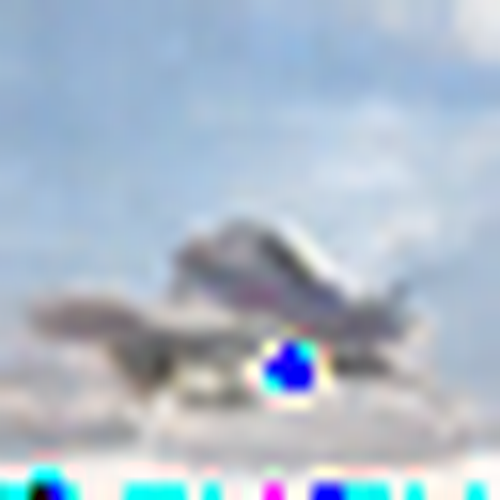

In [26]:
from IPython import display
from PIL import Image
import numpy as np
from IPython.display import display

transform = transforms.ToPILImage()

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    img_pil = transform(img)
    # npimg = np.transpose(npimg, (1, 2, 0))
     # Print image shape and data range for debugging
    # print("Image shape:", npimg.shape)
    # print("Min pixel value:", np.min(npimg))
    # print("Max pixel value:", np.max(npimg))
    # img_pil = Image.fromarray((npimg * 255).astype(np.uint8))
    img = img_pil.resize((500, 500), Image.LANCZOS)
    display(img)

z = torch.cuda.FloatTensor(np.random.normal(0, 1, (1, 1024)))
fake = G(z)
# Assuming 'generated_image' contains the generated image tensor of shape (1, 3, 32, 32)
imshow(fake.squeeze())

In [13]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch import nn
import torch.optim as optim

# Define loss function
criterion = nn.MSELoss()

# Load pre-trained transformer (e.g., ResNet50)
feature_extractor = resnet50(pretrained=True)
# feature_extractor.eval()
# transformer.eval()

# Freeze transformer parameters
for param in feature_extractor.parameters():
    param.requires_grad = True

# Define mapping function
class ImageToNoiseMapper(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ImageToNoiseMapper, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

# Define optimizer for mapper
optimizer = optim.Adam(feature_extractor.parameters(), lr=0.001)

# Define transformations for CIFAR-10 images
transform = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define CIFAR-10 train dataset and data loader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
losses = []
# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 3
# Training loop
# Training loop
b = len(trainloader)
for epoch in range(num_epochs):
    j = 0
    for input_image, _ in trainloader:
        j += 1
        # Move input image to device
        input_image = input_image
        # Forward pass through feature extractor
        features = feature_extractor(input_image)
        
        # Flatten or reshape features
        # Flatten or reshape features
        batch_size, features_dim = features.shape[:2]  # Extract batch size and features dimension
        flattened_features = features.view(batch_size, -1)
        # Forward pass through generator
        output_dim = 1024  # Assuming noise vector size
        mapper = ImageToNoiseMapper(features_dim, output_dim)
        noise_vector = mapper(flattened_features)
        generated_image = G(noise_vector.to(device))

        # Compute loss between generated image and input image
        loss = criterion(generated_image.to('cpu'), input_image.to('cpu'))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # Print loss
        print(f"Epoch [{epoch+1}/{num_epochs}],Batch {j}/{b} Loss: {loss.item()}")
#         wandb.log({'EpochFeat': epoch+1,'Batch': j,'FeatureLoss':loss.item()})



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s] 


100%|██████████| 170498071/170498071 [00:02<00:00, 59018525.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [15]:
class ENCODER(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)  #out 16x16
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) #out 8x8
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1) #out 4x4
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1) #out 2x2

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x

In [30]:
def ImgNoise(input_image):
    feature_extractor.eval()
    # Freeze transformer parameters
    # Freeze transformer parameters
    for param in feature_extractor.parameters():
        param.requires_grad = False
    input_image = input_image.to('cpu')
    features = feature_extractor(input_image)
    
    batch_size, features_dim = features.shape[:2]  # Extract batch size and features dimension
    flattened_features = features.view(batch_size, -1)
    # Forward pass through generator
    output_dim = 1024  # Assuming noise vector size
    mapper = ImageToNoiseMapper(features_dim, output_dim)
    noise_vector = mapper(flattened_features).to("cuda")
    
    return noise_vector

In [37]:
class GAN_SOTA(pl.LightningModule):
    def __init__(self, lr=0.0002, display=False, display_end=False, b1=0.5, b2=0.999):
        super().__init__()
        self.lr = lr
        self.display = display
        self.display_end = display_end

        self.save_hyperparameters()
        self.G = G
        self.Enc = ENCODER()
        self.D_norm = Discriminator(diff_aug = "translation,cutout,color", image_size=32, patch_size=4, input_channel=3, num_classes=1,
                 dim=384, depth=7, heads=4, mlp_ratio=4,
                 drop_rate=0.)
        self.D_anom = Discriminator(diff_aug = "translation,cutout,color", image_size=32, patch_size=4, input_channel=3, num_classes=1,
                 dim=384, depth=7, heads=4, mlp_ratio=4,
                 drop_rate=0.)
        self.D_anom.load_state_dict(checkpoint['discriminator_state_dict'])
        self.D_norm.load_state_dict(checkpoint['discriminator_state_dict'])
        self.G.load_state_dict(checkpoint['generator_state_dict'])
        self.automatic_optimization = False
        self.test_step_outputs = [[], []]  # two dataloaders
        self.auroc = 0
        self.last_batch = None
#         wandb.watch(self.G)
#         wandb.watch(self.D_norm)
#         wandb.watch(self.D_anom)
        
    def forward(self, x):
        return self.G(ImgNoise(x))

    def print_generator_parameters(self):
        for name, param in self.G.named_parameters():
            print(f"Generator Parameter Name: {name}")
            print(f"Parameter Value:\n{param}")

    def patch_loss(self, X, generated_X, n=3):

        # Calculate the L1 loss for each patch
        patch_errors = torch.abs(X - generated_X)
        patch_errors_reshaped = patch_errors.view(patch_errors.size(0), patch_errors.size(1), -1)

        # compute loss for each patch
        mean_patch_errors = patch_errors_reshaped.mean(dim=-1)

        # Select the top n patches
        sorted_patch_indices = torch.argsort(mean_patch_errors, dim=-1, descending=True)
        top_patch_indices = sorted_patch_indices[:, :n]

        # Calculate the average of the top n patch errors
        top_patch_errors = torch.gather(mean_patch_errors, dim=-1, index=top_patch_indices)
        avg_top_patch_errors = top_patch_errors.mean()
        return avg_top_patch_errors

    # Utilities to print batches during training
    def show_batch_image(self, batch):
        X, Y = batch
        image = X[0].detach().cpu().numpy()
        plt.figure(figsize=(5, 5))
        plt.title("Label: {}".format(Y[0]))
        plt.imshow(image[0], cmap='gray')
        plt.axis('off')
        plt.show()


    #The generator is trained to output 1 from normal data and 0 from anomaly data
    def training_step(self, batch, batch_idx):
        g_opt, d_norm_opt, d_anom_opt = self.optimizers()

        X, Y = batch
        self.last_batch = batch
        batch_size = X.shape[0]

        real_label = torch.ones((batch_size, 1), device=self.device)
        fake_label = torch.zeros((batch_size, 1), device=self.device)

        errD_anomal = 0
        errD_normal = 0

        # Patch embedding
        patch_size = 4
        embed_dim = 384
#         patch_embedding = PatchEmbedding(patch_size, 1, embed_dim)
        
        x = ImgNoise(X)

        # Normal Case
        if (Y.squeeze() == 1):
            x = ImgNoise(X)
            generated_X = self.G(x)

            # print("---\t", X.shape, generated_X.shape)
            # print("\n")
            discriminated_X = self.D_norm(X)
            discriminated_G = self.D_norm(generated_X)
            encoded_X = self.Enc(X)
            # Optimize Discriminator #
            d_norm_opt.zero_grad()
            
#             print(discriminated_G.shape, discriminated_X.shape,fake_label.shape, real_label.shape)
            # NORM ADV LOSS
            Norm_adv_loss = (((discriminated_X - real_label)**2) + ((discriminated_G - fake_label)**2))

            errD_normal = (Norm_adv_loss.mean())

            errD = errD_normal
            self.manual_backward(errD_normal.mean())
            d_norm_opt.step()

            # Optimize Generator #
            g_opt.zero_grad()
            x = ImgNoise(X)
            generated_X = self.G(x)
            # print("---\t", X.shape, generated_X.shape)
            discriminated_X = self.D_norm(X)
            discriminated_G = self.D_norm(generated_X)
            encoded_X = self.Enc(generated_X)

            # L1 RECONSTRUCTION ERROR
            l1_loss = F.l1_loss(X, generated_X)

            # PATCH L1 LOSS
            patch_loss = self.patch_loss(X, generated_X)

            # LATENT VECTOR LOSS
            latent_loss = F.l1_loss(encoded_X, self.Enc(generated_X))

            # ADVERSARIAL LOSS
            norm_adv_loss = ((discriminated_G - real_label)**2)

            errG_normal = patch_loss*(1.5) + (norm_adv_loss)*(0.5) + (latent_loss)*(0.5) + (l1_loss)*(1.5)
            errG = errG_normal.mean()
            self.manual_backward(errG_normal.mean())
            g_opt.step()
#             wandb.log({"g_loss": torch.tensor(errG).mean(), "d_normal_loss": torch.tensor(errD).mean()})
            self.log_dict({"g_loss": torch.tensor(errG).mean(), "d_normal_loss": torch.tensor(errD).mean()}, prog_bar=True)

        # Anomal Case
        else:
            x = ImgNoise(X)
            generated_X = self.G(x)
            # print("---\t", X.shape, generated_X.shape)
            # print("\n")
            discriminated_X = self.D_anom(X)
            discriminated_G = self.D_anom(generated_X)

            # Optimize Discriminator #
            d_anom_opt.zero_grad()

            # ANOM ADV LOSS
#             print(discriminated_G.shape, discriminated_X.shape,fake_label.shape, real_label.shape )
            Anom_adv_loss = ((((discriminated_X - real_label)**2) + ((discriminated_G - fake_label)**2)))

            errD_anomal = (Anom_adv_loss.mean())

            errD = errD_anomal
            self.manual_backward(errD_anomal.mean())
            d_anom_opt.step()

            # Optimize Generator #
            g_opt.zero_grad()
            x = ImgNoise(X)
            generated_X = self.G(x)
            discriminated_X = self.D_anom(X)
            discriminated_G = self.D_anom(generated_X)
            encoded_X = self.Enc(X)
            
#             print(discriminated_G.shape, discriminated_X.shape,fake_label.shape, real_label.shape )
            # ANOM ADVERS LOSS
            anom_adv_loss = ((discriminated_G - fake_label)**2)

            # ABC LOSS
            abc_loss = -torch.log(1 - torch.exp(-F.l1_loss(generated_X, X)))

            errG_anomal = anom_adv_loss*(1) + (abc_loss)*(0.5)
            errG = errG_anomal.mean()
            self.manual_backward(errG_anomal.mean())
            g_opt.step()

            self.log_dict({"g_loss": errG, "d_anomal_loss": errD}, prog_bar=True)
#             wandb.log({"g_loss": errG, "d_anomal_loss": errD})
#             wandb.log({"generated_images": [wandb.Image(generated_X[i].cpu().detach().numpy()) for i in range(batch_size)]})

        return {"g_loss": errG, "d_norm_loss": errD_normal, "d_anom_loss": errD_anomal}


    def test_step(self, batch, batch_idx):

        X, Y = batch
        x = ImgNoise(X).to("cuda")
        generated_X = self.G(x)

        # Calculate reconstruction error
        reconstruction_error = F.mse_loss(generated_X, X, reduction='none')
        reconstruction_error = reconstruction_error.view(reconstruction_error.size(0), -1).mean(dim=1)
        self.test_step_outputs[0].append(reconstruction_error)
        self.test_step_outputs[1].append(Y)

        if self.display:
            print("generated_X:", generated_X)
            print("reconstruction_error:", reconstruction_error)
            self.show_batch_image(batch)

        return {"reconstruction_error": reconstruction_error, "true_labels": Y}


    def on_test_epoch_end(self):
        all_reconstruction_errors = torch.cat(self.test_step_outputs[0])
        all_true_labels = torch.cat(self.test_step_outputs[1])

        anomaly_threshold = 0.5
        predicted_labels = (all_reconstruction_errors < anomaly_threshold).float().cpu().numpy()
        true_labels = all_true_labels.squeeze().float().cpu().numpy()

        # Calculate AUROC
        auroc = roc_auc_score(true_labels, predicted_labels)

        self.log("auroc", (auroc), prog_bar=True)
        self.auroc = auroc

        self.test_step_outputs = [[], []]


    def on_train_epoch_end(self):
        self.log('g_loss_epoch', self.trainer.logged_metrics['g_loss'].mean(), prog_bar=True)
        self.log('d_anomal_loss_epoch', self.trainer.logged_metrics['d_anomal_loss'].mean(), prog_bar=True)
        self.log('d_normal_loss_epoch', self.trainer.logged_metrics['d_normal_loss'].mean(), prog_bar=True)


        if self.display_end:
            input_image_path = "./0.png"
            input_image = Image.open(input_image_path).convert('L')  # Convert to grayscale
            preprocess = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
            ])
            input_tensor = preprocess(input_image).unsqueeze(0).cuda()
            # Generate output using the trained model
            generated_output = self.G(input_tensor)

            # Convert generated output tensor to an image
            generated_image = generated_output.squeeze().detach().cpu()

            reconstruction_error = F.mse_loss(model(input_tensor), input_tensor, reduction='none')
            reconstruction_error = reconstruction_error.view(reconstruction_error.size(0), -1).mean(dim=1)

            print("\nReconstruction error:", reconstruction_error)
            # Display input and generated images
            plt.figure(figsize=(9, 4))
            string = 'Input vs. Generated Image'
            plt.suptitle(string, fontsize=16)
            plt.subplot(1, 2, 1)
            plt.title('Input Image')
            plt.imshow(input_image, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title('Generated Image')
            plt.imshow(generated_image, cmap='gray')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    # Manually optimize the 3 parts
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.G.parameters(), lr=self.lr, betas=(b1, b2))
        opt_d_norm = torch.optim.Adam(self.D_norm.parameters(), lr=self.lr, betas=(b1, b2))
        opt_d_anom = torch.optim.Adam(self.D_anom.parameters(), lr=self.lr, betas=(b1, b2))
        return opt_g, opt_d_norm, opt_d_anom

In [38]:
# Hyperparameters
BATCH_SIZE = 1
epochs = 7
learning_rate = 0.0001
subsampling = False
subsamples = 1000
accelerator_enabled = True
display = False
display_end = False

In [39]:
# Utilities
checkpoint_path = './GAN/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="GAN_ckpt",
    monitor='auc',
    mode='min',
    save_last=True,
    save_top_k=-1,
)


In [40]:
# Initialize dataset
data_module = AnomalyDetectionDataModule(batch_size=BATCH_SIZE,
                                         subsampling=subsampling,
                                         subsamples=subsamples,
                                         model='GAN',
                                         normal_class=0)


In [41]:
# Initialize models and trainers
if torch.cuda.is_available() and accelerator_enabled:
  print("GPU")
  model = GAN_SOTA(lr=learning_rate,
                   display=display,
                   display_end=display_end).to("cuda")

  trainer = pl.Trainer(accelerator="cuda",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )
else :
  print("CPU")
  model = GAN_SOTA(lr=learning_rate,
                   display=display,
                   display_end=display_end).to("cpu")

  trainer = pl.Trainer(accelerator="cpu",
                       max_epochs=epochs,
                       callbacks=[TQDMProgressBar(),
                                  checkpoint_callback]
                       )


GPU


100%|██████████| 170498071/170498071 [00:04<00:00, 38399771.06it/s]


Extracting ./cifar-10-python.tar.gz to ./


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type          | Params
-----------------------------------------
0 | G      | GENERATOR     | 5.5 M 
1 | Enc    | ENCODER       | 2.8 M 
2 | D_norm | DISCRIMINATOR | 298 K 
3 | D_anom | DISCRIMINATOR | 298 K 
-----------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.441    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-6-4313bf74b14d>:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_dict({"g_loss": torch.tensor(errG).mean(), "d_normal_loss": torch.tensor(errD).mean()}, prog_bar=True)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:383: `ModelCheckpoint(monitor='auc')` could not find the monitored key in the returned metrics: ['g_loss', 'd_normal_loss', 'd_anomal_loss', 'g_loss_epoch', 'd_anomal_loss_epoch', 'd_normal_loss_epoch', 'epoch', 'step']. HINT: Did you call `log('auc', value)` in the `LightningModule`?
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

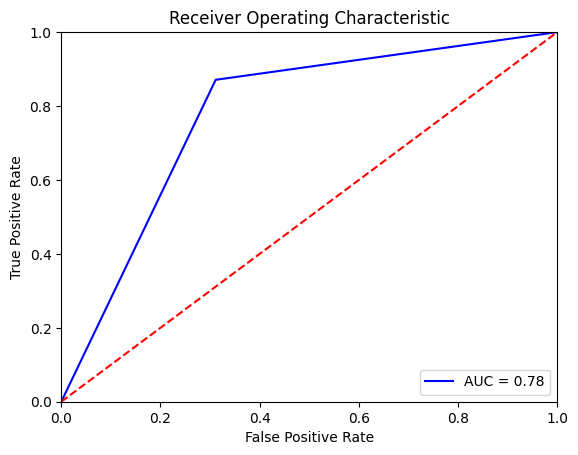

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           auroc           │     0.779844343662262     │
└───────────────────────────┴───────────────────────────┘

[{'auroc': 0.779844343662262}]


In [11]:
# Train and save
trainer.fit(model, data_module)
trainer.save_checkpoint("/GAN/checkpoints/GAN_0.ckpt")
torch.save(model.state_dict(), "./GAN/GAN_0")

# Testing
test_results = trainer.test(model, data_module)
print(test_results)